<a href="https://colab.research.google.com/github/Giraldo0712/TAM_2025_2/blob/main/Parcial_2/doom_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# 1. BLOQUE DE INSTALACIÓN (MODO EXORCISMO)
# ==========================================

# 1. Dependencias de Linux
!sudo apt-get update
!sudo apt-get install -y cmake libboost-all-dev libsdl2-dev libopenal-dev timidity

# 2. ELIMINAR TENSORFLOW (El causante del conflicto con sklearn/numpy)
# Al quitar esto, evitamos que Keras intente cargar Sklearn y rompa todo.
!pip uninstall -y tensorflow tensorflow-intel tensorflow-io-gcs-filesystem tensorboard

# 3. Limpiar el resto del stack
!pip uninstall -y gymnasium gym vizdoom shimmy stable-baselines3 numpy scipy matplotlib scikit-learn pandas

# 4. INSTALAR NUMPY 1.x PRIMERO (La base de todo)
!pip install "numpy==1.26.4"

# 5. Instalar stack científico compatible
!pip install "scipy==1.13.1" "matplotlib==3.8.4" "scikit-learn==1.3.2" "pandas==2.2.2"

# 6. Instalar Tensorboard limpio (sin Tensorflow) y el stack de RL
!pip install tensorboard
!pip install vizdoom gymnasium==0.29.1 stable-baselines3[extra] imageio shimmy>=1.3.0 --quiet

print("✅ Instalación completada. TENSORFLOW ELIMINADO.")
print("⚠️ IMPORTANTE: VE AHORA MISMO A 'RESTART & CLEAR CELL OUTPUTS'.")

In [ ]:
import gymnasium as gym
import vizdoom.gymnasium_wrapper
import numpy as np
from PIL import Image
from gymnasium import ObservationWrapper, ActionWrapper, spaces
from gymnasium.wrappers import FrameStack

# ==========================================
# 1. WRAPPER CON PIL (CORREGIDO PARA SB3)
# ==========================================
class VizdoomPILWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # CORRECCIÓN: La forma base es (84, 84).
        # FrameStack agregará la dimensión 4 automáticamente -> (4, 84, 84)
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(84, 84), dtype=np.uint8
        )

    def observation(self, observation):
        # A. Extracción segura
        if isinstance(observation, dict):
            if "screen" in observation:
                img = observation["screen"]
            else:
                candidates = sorted([v for k, v in observation.items()], key=lambda x: np.array(x).size, reverse=True)
                img = candidates[0]
        else:
            img = observation

        # B. Convertir a Numpy Array Limpio
        img = np.array(img, dtype=np.uint8)

        # C. Corrección de Canales (HWC -> CHW si es necesario)
        if img.ndim == 3 and img.shape[0] in [1, 3]:
            img = np.transpose(img, (1, 2, 0))

        # D. USAR PIL PARA PROCESAR
        try:
            pil_img = Image.fromarray(img)
            pil_img = pil_img.convert("L") # Grises
            pil_img = pil_img.resize((84, 84), resample=Image.BILINEAR)

            processed_obs = np.array(pil_img)

            # CORRECCIÓN: NO agregamos dimensión extra.
            # Dejamos que sea (84, 84). FrameStack hará el resto.

            return processed_obs

        except Exception as e:
            print(f"❌ Error en PIL: {e}")
            return np.zeros((84, 84), dtype=np.uint8)

class VizdoomActionWrapper(ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space = env.action_space
    def action(self, action):
        return int(action)

# ==========================================
# 2. EJECUCIÓN
# ==========================================
env = gym.make("VizdoomDefendCenter-v0", render_mode="rgb_array")

# Aplicar Wrappers
env = VizdoomPILWrapper(env)
env = FrameStack(env, num_stack=4) # Esto convierte (84,84) en (4, 84, 84)
env = VizdoomActionWrapper(env)

# Verificación
print("\n🔄 Verificando forma corregida...")
obs, _ = env.reset()
obs_data = np.array(obs)

print("✅ ¡LISTO PARA SB3!")
print(f"Forma Final: {obs_data.shape}")
# DEBE SER: (4, 84, 84) -> Perfecto para CnnPolicy

/usr/local/lib/python3.11/dist-packages/vizdoom/gymnasium_wrapper/base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(



🔄 Verificando forma corregida...
✅ ¡LISTO PARA SB3!
Forma Final: (4, 84, 84)


/tmp/ipykernel_3602/1859100460.py:75: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  obs_data = np.array(obs)


📸 Generando visualización...
Observación a graficar: (4, 84, 84)


/tmp/ipykernel_3602/3684773510.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  obs_data = np.array(obs)


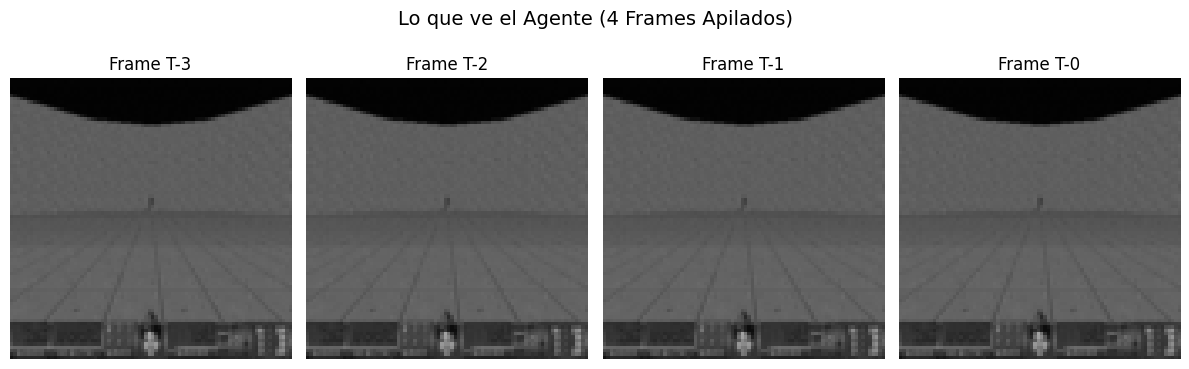

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ================================
# VERIFICACIÓN VISUAL (AJUSTADA)
# ================================

print("📸 Generando visualización...")

obs, _ = env.reset()
obs_data = np.array(obs)

print(f"Observación a graficar: {obs_data.shape}")
# Esperamos (4, 84, 84)

plt.figure(figsize=(12, 4))
plt.suptitle(f"Lo que ve el Agente (4 Frames Apilados)", fontsize=14)

for i in range(4):
    ax = plt.subplot(1, 4, i + 1)

    # Ahora obs_data[i] es directamente una imagen (84, 84)
    frame = obs_data[i]

    plt.imshow(frame, cmap="gray", vmin=0, vmax=255)
    plt.title(f"Frame T-{3-i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

🚀 INICIANDO ENTRENAMIENTO LARGO EN cuda...
Objetivo: 30 bloques de 80000 pasos.
☕ Ve por un café, esto tomará unas 2.5 - 3 horas.

⚡ Entrenando Bloque 1/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

/tmp/ipykernel_3602/3892964728.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  obs = np.array(obs) # Fix para LazyFrames
/tmp/ipykernel_3602/3892964728.py:44: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  obs = np.array(obs) # Fix para LazyFrames


📈 Recompensa media bloque 1: 1.00

⚡ Entrenando Bloque 2/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 2: 6.60

⚡ Entrenando Bloque 3/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 3: 2.00

⚡ Entrenando Bloque 4/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 4: 5.00

⚡ Entrenando Bloque 5/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 5: 5.40

⚡ Entrenando Bloque 6/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 6: 4.40

⚡ Entrenando Bloque 7/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 7: 3.80

⚡ Entrenando Bloque 8/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 8: 6.80

⚡ Entrenando Bloque 9/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 9: 8.00

⚡ Entrenando Bloque 10/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 10: 3.80

⚡ Entrenando Bloque 11/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 11: 4.60

⚡ Entrenando Bloque 12/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 12: 11.20

⚡ Entrenando Bloque 13/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 13: 8.80

⚡ Entrenando Bloque 14/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 14: 16.00

⚡ Entrenando Bloque 15/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 15: 15.20

⚡ Entrenando Bloque 16/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 16: 5.80

⚡ Entrenando Bloque 17/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 17: 9.20

⚡ Entrenando Bloque 18/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 18: 14.60

⚡ Entrenando Bloque 19/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 19: 10.40

⚡ Entrenando Bloque 20/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 20: 14.20

⚡ Entrenando Bloque 21/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 21: 9.80

⚡ Entrenando Bloque 22/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 22: 13.60

⚡ Entrenando Bloque 23/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 23: 13.40

⚡ Entrenando Bloque 24/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 24: 15.00

⚡ Entrenando Bloque 25/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 25: 17.80

⚡ Entrenando Bloque 26/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 26: 14.20

⚡ Entrenando Bloque 27/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 27: 12.40

⚡ Entrenando Bloque 28/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 28: 12.40

⚡ Entrenando Bloque 29/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 29: 14.80

⚡ Entrenando Bloque 30/30...


Entrenando bloque actual:   0%|          | 0/80000 [00:00<?, ?it/s]

📈 Recompensa media bloque 30: 17.80

🏆 ENTRENAMIENTO FINALIZADO.


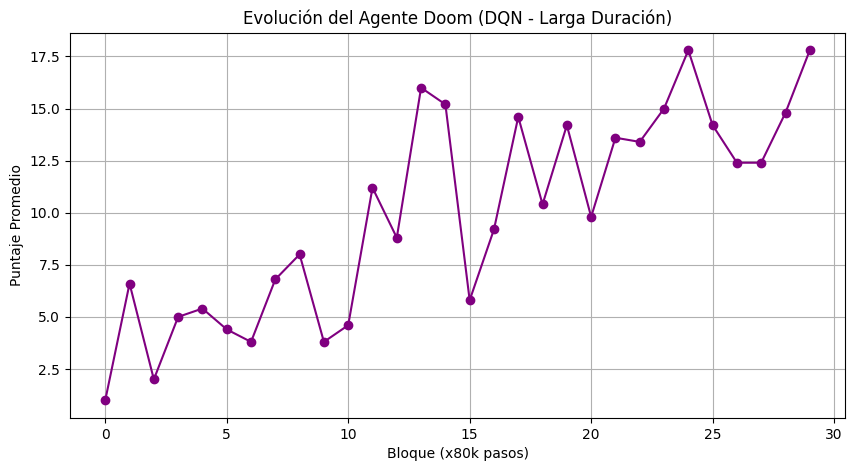

In [ ]:
import numpy as np
import gc
import torch
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# =========================================================
# 1. Callback Barra de Progreso
# =========================================================
class ProgressBarCallback(BaseCallback):
    def __init__(self, total_timesteps, verbose=0):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
        self.pbar = None

    def _on_training_start(self):
        self.pbar = tqdm(total=self.total_timesteps, desc="Entrenando bloque actual")

    def _on_step(self):
        if self.pbar:
            self.pbar.update(1)
        return True

    def _on_training_end(self):
        if self.pbar:
            self.pbar.close()

# =========================================================
# 2. Evaluación del Agente (Blindado con np.array)
# =========================================================
def evaluar_agente(model, env, episodios=5):
    recompensas = []
    for _ in range(episodios):
        obs, _ = env.reset()
        obs = np.array(obs) # Fix para LazyFrames
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            obs = np.array(obs) # Fix para LazyFrames

            done = terminated or truncated
            total_reward += reward

        recompensas.append(total_reward)
    return np.mean(recompensas)

# =========================================================
# 3. Configuración del Modelo PRO
# =========================================================
model = DQN(
    policy="CnnPolicy",
    env=env,
    learning_rate=1e-4,             # Velocidad estándar
    buffer_size=100_000,            # Memoria grande
    learning_starts=10_000,         # Espera un poco antes de aprender
    batch_size=32,
    train_freq=4,
    target_update_interval=10_000,  # Estabilidad
    exploration_fraction=0.3,       # Explora el 30% del tiempo (aprox 1 hora)
    exploration_final_eps=0.01,     # Al final solo explora el 1%
    verbose=0,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# =========================================================
# 4. BUCLE DE ENTRENAMIENTO (EL LARGO)
# =========================================================
blocks = 30                 # 30 Bloques
steps_per_block = 80_000    # 80k pasos (Total 2.4 Millones)

recompensas_bloques = []
print(f"🚀 INICIANDO ENTRENAMIENTO LARGO EN {model.device}...")
print(f"Objetivo: {blocks} bloques de {steps_per_block} pasos.")
print("☕ Ve por un café, esto tomará unas 2.5 - 3 horas.")

for i in range(blocks):
    print(f"\n⚡ Entrenando Bloque {i+1}/{blocks}...")

    model.learn(
        total_timesteps=steps_per_block,
        reset_num_timesteps=False,
        callback=ProgressBarCallback(steps_per_block)
    )

    # Guardar checkpoint (Por si se va la luz o se cae Kaggle)
    path = f"dqn_doom_block_{i+1}"
    model.save(path)

    # Evaluación
    rew = evaluar_agente(model, env)
    recompensas_bloques.append(rew)
    print(f"📈 Recompensa media bloque {i+1}: {rew:.2f}")

    # Limpieza de RAM
    del model
    gc.collect()
    torch.cuda.empty_cache()

    # Recargar para seguir
    model = DQN.load(path, env=env)

# Guardado final
model.save("dqn_doom_final_master")
print("\n🏆 ENTRENAMIENTO FINALIZADO.")

# Graficar Progreso
plt.figure(figsize=(10,5))
plt.plot(recompensas_bloques, marker='o', color='purple')
plt.title("Evolución del Agente Doom (DQN - Larga Duración)")
plt.xlabel("Bloque (x80k pasos)")
plt.ylabel("Puntaje Promedio")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from stable_baselines3 import DQN

# ==========================================
# CORRECCIÓN: Cargar el modelo de la PRUEBA (_v2)
# ==========================================
# Si el archivo se llamaba "dqn_doom_final_v2.zip", lo cargamos así:
try:
    model = DQN.load("dqn_doom_final_v2", env=env)
    print("✅ Modelo cargado: dqn_doom_final_v2")
except FileNotFoundError:
    # Por si acaso usaste otro nombre, intentamos el genérico
    print("⚠️ No encontré _v2, intentando cargar 'dqn_doom_final'...")
    model = DQN.load("dqn_doom_final", env=env)

def run_test(agent_type="trained", episodes=10): # Bajamos episodios para que sea rápido
    rewards = []
    desc = f"Test {agent_type}"

    for _ in tqdm(range(episodes), desc=desc):
        obs, _ = env.reset()
        obs = np.array(obs) # Fix LazyFrames
        done = False
        total_reward = 0

        while not done:
            if agent_type == "trained":
                action, _ = model.predict(obs, deterministic=True)
            else:
                action = env.action_space.sample()

            obs, reward, terminated, truncated, _ = env.step(action)
            obs = np.array(obs) # Fix LazyFrames

            done = terminated or truncated
            total_reward += reward

        rewards.append(total_reward)

    return np.mean(rewards), np.std(rewards)

# Ejecutar comparativa
mean_tr, std_tr = run_test("trained")
mean_rn, std_rn = run_test("random")

print("\n===== RESULTADOS DE LA PRUEBA RÁPIDA =====")
print(f"🤖 Agente IA (Entrenado): {mean_tr:.2f} ± {std_tr:.2f}")
print(f"🎲 Agente Tonto (Random): {mean_rn:.2f} ± {std_rn:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Modelo cargado: dqn_doom_final_v2


Test trained:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_3602/1224793506.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  obs = np.array(obs) # Fix LazyFrames
/tmp/ipykernel_3602/1224793506.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  obs = np.array(obs) # Fix LazyFrames


Test random:   0%|          | 0/10 [00:00<?, ?it/s]


===== RESULTADOS DE LA PRUEBA RÁPIDA =====
🤖 Agente IA (Entrenado): 0.20 ± 0.40
🎲 Agente Tonto (Random): 0.00 ± 0.89


In [ ]:
import imageio
import numpy as np
from IPython.display import Video, display
from stable_baselines3 import DQN

video_path = "doom_gameplay_master.mp4"
frames = []

# Cargar explícitamente el modelo maestro
print("Cargando modelo maestro...")
model = DQN.load("dqn_doom_final_master", env=env)

# Resetear entorno
obs, _ = env.reset()
obs = np.array(obs)
done = False

# Render inicial
img_render = env.render()
if img_render is not None:
    frames.append(img_render)

print("🎥 Grabando partida del agente EXPERTO...")

pasos = 0
max_pasos = 2000

while not done and pasos < max_pasos:
    # Agente decide
    action, _ = model.predict(obs, deterministic=True)

    # Entorno avanza
    obs, _, terminated, truncated, _ = env.step(action)
    obs = np.array(obs) # Fix LazyFrames
    done = terminated or truncated

    # Captura frame HD
    img_render = env.render()
    if img_render is not None:
        frames.append(img_render)

    pasos += 1

if len(frames) > 0:
    imageio.mimsave(video_path, frames, fps=30)
    print(f"✅ Video guardado: {video_path} ({len(frames)} frames)")
    display(Video(video_path, embed=True, width=640, html_attributes="controls autoplay loop"))
else:
    print("❌ Error: No se capturaron frames.")

Cargando modelo maestro...
🎥 Grabando partida del agente EXPERTO...


/tmp/ipykernel_3602/4099224219.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  obs = np.array(obs)
/tmp/ipykernel_3602/4099224219.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  obs = np.array(obs) # Fix LazyFrames


✅ Video guardado: doom_gameplay_master.mp4 (863 frames)
